Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [47]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [48]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [49]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = 'gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [50]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [51]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [52]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the datase
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [53]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [54]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

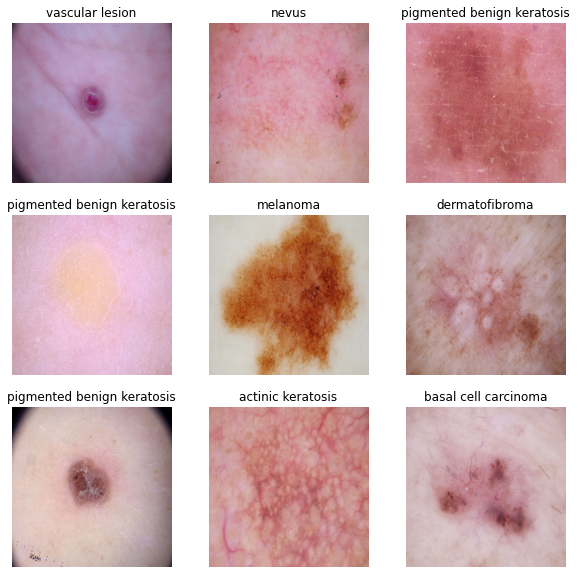

In [55]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [57]:
### Your code goes here

num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [58]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [60]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 46ms/step - loss: 1.9659 - accuracy: 0.2662 - val_loss: 1.7705 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 1.6510 - accuracy: 0.4235 - val_loss: 1.6197 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 1.5454 - accuracy: 0.4559 - val_loss: 1.4892 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.4567 - accuracy: 0.4905 - val_loss: 1.4185 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 15ms/step - loss: 1.3086 - accuracy: 0.5379 - val_loss: 1.4362 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 1.2750 - accuracy: 0.5513 - val_loss: 1.3974 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 1.1584 - accuracy: 0.5904 - val_loss: 1.4421 - val_accuracy: 0.5145
Epoch 8/20
56

### Visualizing training results

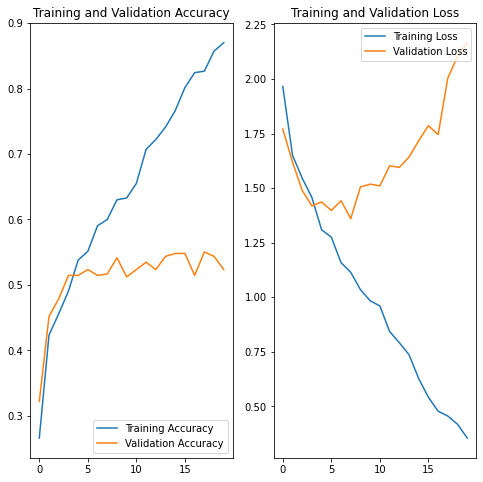

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- Training accuracy of the model seems to increase linearly while the validation accuracy has stopped increasing after 55% around. 
- Higher training accuracy and low validation accuracy means the model has memorised the data and is overfitting. 
- To avoid the overfitting, augmentation technique will be used. Since the training data available is less, we will generate new samples by slightly modifying the existing training data (for eg. flipping the image horizontally/vertically, slightly rotating the image etc) and use them for training the model as well.

In [62]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

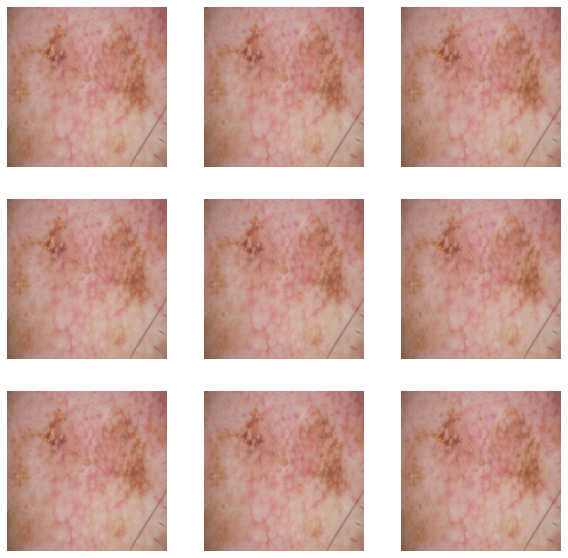

In [63]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [64]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [65]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [66]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 20ms/step - loss: 1.9339 - accuracy: 0.2840 - val_loss: 1.6667 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 1.5945 - accuracy: 0.4358 - val_loss: 1.4814 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 1.4826 - accuracy: 0.4587 - val_loss: 1.5669 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 1.4223 - accuracy: 0.5084 - val_loss: 1.4151 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3228 - accuracy: 0.5318 - val_loss: 1.2824 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 1s 18ms/step - loss: 1.2910 - accuracy: 0.5391 - val_loss: 1.7092 - val_accuracy: 0.3937
Epoch 7/20
56/56 [==============================] - 1s 18ms/step - loss: 1.3158 - accuracy: 0.5195 - val_loss: 1.3110 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

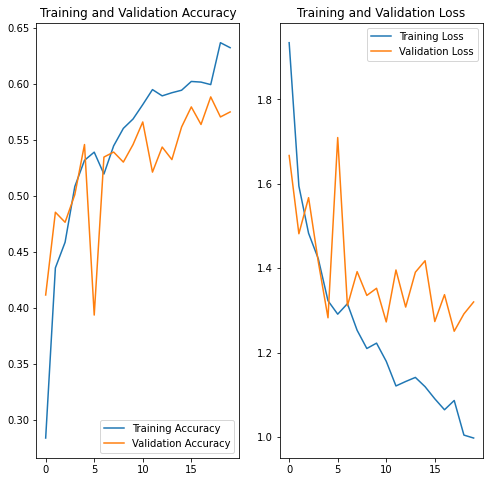

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- With the help of augmented data, the problem of overfitting is avoided.
- Training and validation accuracy of the above model are in the same range.
- Since the training and validation accuracy both are low, the model seems to undefit now. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [68]:
## Your code goes here.

from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesion_list))

2239


In [69]:
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/ISIC_0024885.jpg', 'basal cell carcinoma'), ('gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/ISIC_0024984.jpg', 'basal cell carcinoma')]


In [70]:
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,gdrive/My Drive/Colab_Notebooks/CNN_melanoma_a...,basal cell carcinoma
1,gdrive/My Drive/Colab_Notebooks/CNN_melanoma_a...,basal cell carcinoma
2,gdrive/My Drive/Colab_Notebooks/CNN_melanoma_a...,basal cell carcinoma
3,gdrive/My Drive/Colab_Notebooks/CNN_melanoma_a...,basal cell carcinoma
4,gdrive/My Drive/Colab_Notebooks/CNN_melanoma_a...,basal cell carcinoma


In [71]:
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

- These are the no of images present currently. We will add more images to avoid underfitting

In [72]:
original_df[['Label']].value_counts(normalize=True)


Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
dtype: float64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- 'seborrheic keratosis' has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
- the classes 'pigmented benign keratosis' and 'melanoma' dominate the data with 20.6% and 19.5% samples respectively.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [73]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [74]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBF8242210>: 100%|██████████| 500/500 [00:09<00:00, 54.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBF2D8E890>: 100%|██████████| 500/500 [00:10<00:00, 45.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBF2B84D50>: 100%|██████████| 500/500 [00:10<00:00, 49.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDBF7F1EF10>: 100%|██████████| 500/500 [00:46<00:00, 10.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBF2D7E790>: 100%|██████████| 500/500 [00:39<00:00, 12.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBF847CE90>: 100%|██████████| 500/500 [00:08<00:00, 58.24 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDBF9AEB890>: 100%|██████████| 500/500 [00:20<00:00, 24.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDBF867DAD0>: 100%|██████████| 500/500 [00:08<00:00, 56.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBF614FE90>: 100%|██████████| 500/500 [00:08<00:00, 56.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [75]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [76]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024848.jpg_02d53465-f167-4d6b-a0bf-8b5b6184da6f.jpg',
 'gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028693.jpg_1ec65535-eb44-4ac8-a2c8-0492a18576ab.jpg',
 'gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028670.jpg_070efa9b-ee34-4041-8f89-491d52e7f05a.jpg',
 'gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025417.jpg_2b23ee74-c33c-4a9d-a983-fa2387ac0089.jpg',
 'gdrive/My Drive/Colab_Notebooks/CNN_melanoma_assignment/skin_cancer_image_data/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028147.jpg_7977eab2-0744-4f21

In [77]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [78]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [79]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [80]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [81]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [82]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [83]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [84]:
# ## your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [85]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [86]:
%%time
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 24s 132ms/step - loss: 1.8510 - accuracy: 0.2990 - val_loss: 1.5066 - val_accuracy: 0.4269
Epoch 2/30
169/169 [==============================] - 18s 105ms/step - loss: 1.5101 - accuracy: 0.4329 - val_loss: 1.3893 - val_accuracy: 0.4878
Epoch 3/30
169/169 [==============================] - 19s 107ms/step - loss: 1.4005 - accuracy: 0.4622 - val_loss: 1.3173 - val_accuracy: 0.5078
Epoch 4/30
169/169 [==============================] - 19s 107ms/step - loss: 1.3354 - accuracy: 0.4946 - val_loss: 1.2699 - val_accuracy: 0.5353
Epoch 5/30
169/169 [==============================] - 18s 106ms/step - loss: 1.2468 - accuracy: 0.5241 - val_loss: 1.2932 - val_accuracy: 0.4967
Epoch 6/30
169/169 [==============================] - 19s 106ms/step - loss: 1.2453 - accuracy: 0.5343 - val_loss: 1.2019 - val_accuracy: 0.5561
Epoch 7/30
169/169 [==============================] - 18s 105ms/step - loss: 1.1616 - accuracy: 0.5555 - val_loss: 1.1005 - val_ac

#### **Todo:**  Visualize the model results

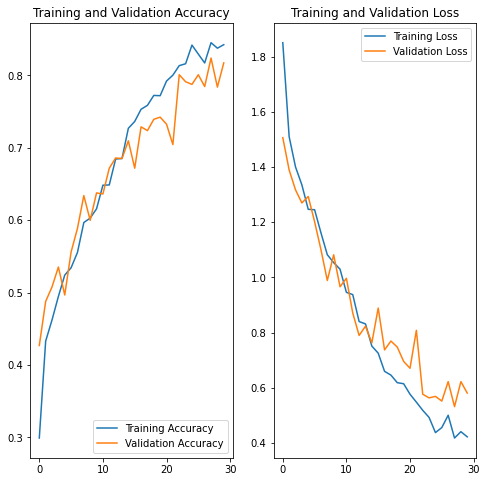

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- The final model is good to go and has no signs of overfitting or underfitting. 
- Class rebalanced improved the model performance on both training and validation data.
- In 30 epochs, the final model is able to achieve 84% training accuracy and 81% validation accuracy.
- The low difference between the training accuracy and validation accuracy signifies that the final CNN model is able to generalize well.
- Inclusion of batch normalization is degrading the accuracy of the final model, hence it is not used.